> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, we select randomly sample 512 x  2 grid points of a solution of ASDM for a 32 x 32 grid, integerated for 0 to 50000 for 512 time steps. 

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model, however, we are looking for the lowest possible number of points that is enough to train the model. On average 2 data point exists for each time step, around 2/1024=0.19% of the data.

In [1]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#tf.logging.set_verbosity(tf.logging.ERROR)

/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs

In [93]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s,
                 X_f, Y_f, T_f, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s
            
            self.X_f = X_f
            self.Y_f = Y_f
            self.T_f = T_f
                        
            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32)#tf.Variable([0.005], dtype=tf.float32)
            self.D_s = tf.constant(0.2, dtype=tf.float32)#tf.Variable([0.2], dtype=tf.float32)
            self.sigma_a = tf.constant(0.0, dtype=tf.float32)#tf.Variable([0.0], dtype=tf.float32)
            self.sigma_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.mu_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.kappa_a = tf.constant(0.25, dtype=tf.float32)#tf.Variable([0.25], dtype=tf.float32)

            # tf placeholders and graph
            self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                         log_device_placement=True))

            self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
            self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
            self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

            self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
            self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")
            
            self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.X_f.shape[1]], name="x_f_tf")
            self.y_f_tf = tf.placeholder(tf.float32, shape=[None, self.Y_f.shape[1]], name="y_f_tf")
            self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.T_f.shape[1]], name="t_f_tf")            
            
            
            self.a_f_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_f_tf")
            self.s_f_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_f_tf")
                        

            self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)
            
            _, _, self.a_f_tf, self.s_f_tf = self.net_ASDM(self.x_f_tf, self.y_f_tf, self.t_f_tf)
            
            _, _, self.a_f_tf, self.s_f_tf = self.net_ASDM(self.x_f_tf, self.y_f_tf, self.t_f_tf)

            self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                        tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

            self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

            self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
            
            self.loss_a_f = tf.reduce_sum(tf.square(self.a_f_tf), name = "loss_a_f")
            
            self.loss_s_f = tf.reduce_sum(tf.square(self.s_f_tf), name = "loss_s_f")

            self.loss = self.loss_1 + self.loss_a + self.loss_s + self.loss_a_f + self.loss_s_f       

            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                    method = 'L-BFGS-B', 
                                                                    options = {'maxiter': 50000,
                                                                               'maxfun': 50000,
                                                                               'maxcor': 50,
                                                                               'maxls': 50,
                                                                               'ftol' : 1.0 * np.finfo(float).eps})        

            self.optimizer_Adam = tf.train.AdamOptimizer()
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    

            init = tf.global_variables_initializer()
            self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss},\n"
              f"D_a: {D_a:.4f}, D_s: {D_s:.4f}\n"
              f"sigma_a: {sigma_a:.4f}, sigma_s: {sigma_s:.4f}\n"
              f"rho_a: {rho_a:.4f}, rho_s: {rho_s:.4f}\n"
              f"mu_a: {mu_a:.4f}, kappa_a: {kappa_a:.4f}\n")
        
      
    def train(self, nIter, early_stop_thresh = None): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s,
                   self.x_f_tf: self.X_f, self.y_f_tf: self.Y_f, self.t_f_tf: self.T_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                loss_a_f_value = self.sess.run(self.loss_a_f, tf_dict)
                loss_s_f_value = self.sess.run(self.loss_s_f, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"          loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      f"          loss_a_f: {loss_a_f_value:.8f}, loss_s_f: {loss_s_f_value:.8f}\n"
                      f"          loss_a_f/N: {loss_a_f_value/N:.8f}, loss_s_f/N: {loss_s_f_value/N:.8f}\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                loss_a_f_value = self.sess.run(self.loss_a_f, tf_dict)
                loss_s_f_value = self.sess.run(self.loss_s_f, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"          loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      f"          loss_a_f: {loss_a_f_value:.8f}, loss_s_f: {loss_s_f_value:.8f}\n"
                      f"          loss_a_f/N: {loss_a_f_value/N:.8f}, loss_s_f/N: {loss_s_f_value/N:.8f}\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss, self.D_a, self.D_s,
        #                                  self.sigma_a, self.sigma_s,
        #                                  self.rho_a, self.rho_s,
        #                                  self.mu_a, self.kappa_a],
        #                        loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [94]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
idx = np.random.choice(N*T, T*8, replace=False)
#idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]


idx2 = np.random.choice(N*T, T*32*2, replace=False)
x_f_train = x[idx2,:]
y_f_train = y[idx2,:]
t_f_train = t[idx2,:]



In [95]:
s_train.shape

(4096, 1)

In [96]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, 
                          x_f_train, y_f_train, t_f_train, layers)
model.train(400000, early_stop_thresh=1000.0)

It: 0, loss_a  : 0.00359465, loss_s  : 1.63871157, loss  : 11603.33,
          loss_a/N: 0.00000088, loss_s/N: 0.00040008, loss/N: 2.83284307,
          loss_a_f: 0.02936745, loss_s_f: 13.11158085
          loss_a_f/N: 0.00000717, loss_s_f/N: 0.00320107
Time:7.08

It: 100, loss_a  : 0.00064106, loss_s  : 0.00889884, loss  : 1100.87,
          loss_a/N: 0.00000016, loss_s/N: 0.00000217, loss/N: 0.26876768,
          loss_a_f: 0.00506066, loss_s_f: 0.07116654
          loss_a_f/N: 0.00000124, loss_s_f/N: 0.00001737
Time:113.19

It: 200, loss_a  : 0.00040449, loss_s  : 0.00685589, loss  : 1098.75,
          loss_a/N: 0.00000010, loss_s/N: 0.00000167, loss/N: 0.26825052,
          loss_a_f: 0.00320308, loss_s_f: 0.05522798
          loss_a_f/N: 0.00000078, loss_s_f/N: 0.00001348
Time:114.05

It: 300, loss_a  : 0.00042846, loss_s  : 0.00803011, loss  : 1094.59,
          loss_a/N: 0.00000010, loss_s/N: 0.00000196, loss/N: 0.26723331,
          loss_a_f: 0.00339048, loss_s_f: 0.06456938
    

It: 3100, loss_a  : 0.00046699, loss_s  : 0.01637846, loss  : 1076.54,
          loss_a/N: 0.00000011, loss_s/N: 0.00000400, loss/N: 0.26282778,
          loss_a_f: 0.00371860, loss_s_f: 0.13069627
          loss_a_f/N: 0.00000091, loss_s_f/N: 0.00003191
Time:114.12

It: 3200, loss_a  : 0.00045419, loss_s  : 0.01786495, loss  : 1071.88,
          loss_a/N: 0.00000011, loss_s/N: 0.00000436, loss/N: 0.26168978,
          loss_a_f: 0.00359783, loss_s_f: 0.14070617
          loss_a_f/N: 0.00000088, loss_s_f/N: 0.00003435
Time:113.51

It: 3300, loss_a  : 0.00036240, loss_s  : 0.01855019, loss  : 1067.22,
          loss_a/N: 0.00000009, loss_s/N: 0.00000453, loss/N: 0.26055211,
          loss_a_f: 0.00286752, loss_s_f: 0.14426222
          loss_a_f/N: 0.00000070, loss_s_f/N: 0.00003522
Time:122.74

It: 3400, loss_a  : 0.00075300, loss_s  : 0.02417981, loss  : 1058.72,
          loss_a/N: 0.00000018, loss_s/N: 0.00000590, loss/N: 0.25847700,
          loss_a_f: 0.00595599, loss_s_f: 0.1856020

In [103]:
model.train(400000, early_stop_thresh=100.0)

It: 0, loss_a  : 0.00054170, loss_s  : 0.03417009, loss  : 999.70,
          loss_a/N: 0.00000013, loss_s/N: 0.00000834, loss/N: 0.24406858,
          loss_a_f: 0.00422527, loss_s_f: 0.25386423
          loss_a_f/N: 0.00000103, loss_s_f/N: 0.00006198
Time:1.14

It: 100, loss_a  : 0.00072891, loss_s  : 0.03795990, loss  : 969.88,
          loss_a/N: 0.00000018, loss_s/N: 0.00000927, loss/N: 0.23678811,
          loss_a_f: 0.00556656, loss_s_f: 0.27379814
          loss_a_f/N: 0.00000136, loss_s_f/N: 0.00006685
Time:113.07

It: 200, loss_a  : 0.00064388, loss_s  : 0.04307535, loss  : 941.13,
          loss_a/N: 0.00000016, loss_s/N: 0.00001052, loss/N: 0.22976871,
          loss_a_f: 0.00495371, loss_s_f: 0.34258622
          loss_a_f/N: 0.00000121, loss_s_f/N: 0.00008364
Time:113.03

It: 300, loss_a  : 0.00071189, loss_s  : 0.05939637, loss  : 921.41,
          loss_a/N: 0.00000017, loss_s/N: 0.00001450, loss/N: 0.22495271,
          loss_a_f: 0.00568312, loss_s_f: 0.49033326
          

In [108]:
model.train(400000, early_stop_thresh=10.0)

It: 0, loss_a  : 0.00194469, loss_s  : 0.14116475, loss  : 106.13,
          loss_a/N: 0.00000047, loss_s/N: 0.00003446, loss/N: 0.02591183,
          loss_a_f: 0.01705554, loss_s_f: 1.27111506
          loss_a_f/N: 0.00000416, loss_s_f/N: 0.00031033
Time:1.14

It: 100, loss_a  : 0.00173361, loss_s  : 0.13395417, loss  : 93.08,
          loss_a/N: 0.00000042, loss_s/N: 0.00003270, loss/N: 0.02272541,
          loss_a_f: 0.01529407, loss_s_f: 1.19534349
          loss_a_f/N: 0.00000373, loss_s_f/N: 0.00029183
Time:112.97

It: 200, loss_a  : 0.00166418, loss_s  : 0.12855566, loss  : 88.24,
          loss_a/N: 0.00000041, loss_s/N: 0.00003139, loss/N: 0.02154399,
          loss_a_f: 0.01472315, loss_s_f: 1.14703107
          loss_a_f/N: 0.00000359, loss_s_f/N: 0.00028004
Time:113.07

It: 300, loss_a  : 0.00160074, loss_s  : 0.12459344, loss  : 84.21,
          loss_a/N: 0.00000039, loss_s/N: 0.00003042, loss/N: 0.02055839,
          loss_a_f: 0.01419059, loss_s_f: 1.10915112
          los

It: 3100, loss_a  : 0.00119445, loss_s  : 0.07717160, loss  : 33.94,
          loss_a/N: 0.00000029, loss_s/N: 0.00001884, loss/N: 0.00828582,
          loss_a_f: 0.01092913, loss_s_f: 0.68795818
          loss_a_f/N: 0.00000267, loss_s_f/N: 0.00016796
Time:113.07

It: 3200, loss_a  : 0.00118389, loss_s  : 0.07638111, loss  : 33.11,
          loss_a/N: 0.00000029, loss_s/N: 0.00001865, loss/N: 0.00808351,
          loss_a_f: 0.01084508, loss_s_f: 0.68095577
          loss_a_f/N: 0.00000265, loss_s_f/N: 0.00016625
Time:113.10

It: 3300, loss_a  : 0.00119113, loss_s  : 0.07537037, loss  : 33.29,
          loss_a/N: 0.00000029, loss_s/N: 0.00001840, loss/N: 0.00812835,
          loss_a_f: 0.01091021, loss_s_f: 0.67367870
          loss_a_f/N: 0.00000266, loss_s_f/N: 0.00016447
Time:112.95

It: 3400, loss_a  : 0.00116782, loss_s  : 0.07471160, loss  : 31.66,
          loss_a/N: 0.00000029, loss_s/N: 0.00001824, loss/N: 0.00772846,
          loss_a_f: 0.01072579, loss_s_f: 0.66595322
      

It: 6200, loss_a  : 0.00097692, loss_s  : 0.05871334, loss  : 18.54,
          loss_a/N: 0.00000024, loss_s/N: 0.00001433, loss/N: 0.00452543,
          loss_a_f: 0.00909495, loss_s_f: 0.52014196
          loss_a_f/N: 0.00000222, loss_s_f/N: 0.00012699
Time:113.03

It: 6300, loss_a  : 0.00096090, loss_s  : 0.05839144, loss  : 18.39,
          loss_a/N: 0.00000023, loss_s/N: 0.00001426, loss/N: 0.00449060,
          loss_a_f: 0.00894160, loss_s_f: 0.51739222
          loss_a_f/N: 0.00000218, loss_s_f/N: 0.00012632
Time:112.98

It: 6400, loss_a  : 0.00096843, loss_s  : 0.05778168, loss  : 17.95,
          loss_a/N: 0.00000024, loss_s/N: 0.00001411, loss/N: 0.00438301,
          loss_a_f: 0.00902270, loss_s_f: 0.51129091
          loss_a_f/N: 0.00000220, loss_s_f/N: 0.00012483
Time:113.01

It: 6500, loss_a  : 0.00096151, loss_s  : 0.05749848, loss  : 17.68,
          loss_a/N: 0.00000023, loss_s/N: 0.00001404, loss/N: 0.00431752,
          loss_a_f: 0.00896107, loss_s_f: 0.50906968
      

It: 9300, loss_a  : 0.00085188, loss_s  : 0.04941234, loss  : 12.32,
          loss_a/N: 0.00000021, loss_s/N: 0.00001206, loss/N: 0.00300876,
          loss_a_f: 0.00800761, loss_s_f: 0.43813634
          loss_a_f/N: 0.00000195, loss_s_f/N: 0.00010697
Time:113.05

It: 9400, loss_a  : 0.00107252, loss_s  : 0.05511157, loss  : 30.38,
          loss_a/N: 0.00000026, loss_s/N: 0.00001345, loss/N: 0.00741793,
          loss_a_f: 0.01014063, loss_s_f: 0.48173040
          loss_a_f/N: 0.00000248, loss_s_f/N: 0.00011761
Time:113.04

It: 9500, loss_a  : 0.00084147, loss_s  : 0.04903238, loss  : 12.04,
          loss_a/N: 0.00000021, loss_s/N: 0.00001197, loss/N: 0.00293868,
          loss_a_f: 0.00791176, loss_s_f: 0.43532735
          loss_a_f/N: 0.00000193, loss_s_f/N: 0.00010628
Time:113.14

It: 9600, loss_a  : 0.00083827, loss_s  : 0.04875994, loss  : 11.90,
          loss_a/N: 0.00000020, loss_s/N: 0.00001190, loss/N: 0.00290438,
          loss_a_f: 0.00788156, loss_s_f: 0.43299878
      

In [113]:
model.train(400000, early_stop_thresh=3.2)

It: 0, loss_a  : 0.00079039, loss_s  : 0.04616866, loss  : 10.00,
          loss_a/N: 0.00000019, loss_s/N: 0.00001127, loss/N: 0.00244119,
          loss_a_f: 0.00744337, loss_s_f: 0.41038048
          loss_a_f/N: 0.00000182, loss_s_f/N: 0.00010019
Time:1.14

It: 100, loss_a  : 0.00079171, loss_s  : 0.04595648, loss  : 9.92,
          loss_a/N: 0.00000019, loss_s/N: 0.00001122, loss/N: 0.00242306,
          loss_a_f: 0.00745239, loss_s_f: 0.40809026
          loss_a_f/N: 0.00000182, loss_s_f/N: 0.00009963
Time:112.86

It: 200, loss_a  : 0.00078408, loss_s  : 0.04596939, loss  : 9.82,
          loss_a/N: 0.00000019, loss_s/N: 0.00001122, loss/N: 0.00239844,
          loss_a_f: 0.00738102, loss_s_f: 0.40844575
          loss_a_f/N: 0.00000180, loss_s_f/N: 0.00009972
Time:112.94

It: 300, loss_a  : 0.00077716, loss_s  : 0.04600251, loss  : 9.86,
          loss_a/N: 0.00000019, loss_s/N: 0.00001123, loss/N: 0.00240673,
          loss_a_f: 0.00731220, loss_s_f: 0.40878502
          loss_a_

It: 3100, loss_a  : 0.00075855, loss_s  : 0.04350614, loss  : 8.90,
          loss_a/N: 0.00000019, loss_s/N: 0.00001062, loss/N: 0.00217211,
          loss_a_f: 0.00720486, loss_s_f: 0.38546830
          loss_a_f/N: 0.00000176, loss_s_f/N: 0.00009411
Time:112.85

It: 3200, loss_a  : 0.00072275, loss_s  : 0.04330539, loss  : 7.73,
          loss_a/N: 0.00000018, loss_s/N: 0.00001057, loss/N: 0.00188629,
          loss_a_f: 0.00685127, loss_s_f: 0.38355964
          loss_a_f/N: 0.00000167, loss_s_f/N: 0.00009364
Time:112.90

It: 3300, loss_a  : 0.00070779, loss_s  : 0.04351250, loss  : 8.00,
          loss_a/N: 0.00000017, loss_s/N: 0.00001062, loss/N: 0.00195408,
          loss_a_f: 0.00669605, loss_s_f: 0.38494962
          loss_a_f/N: 0.00000163, loss_s_f/N: 0.00009398
Time:112.89

It: 3400, loss_a  : 0.00071763, loss_s  : 0.04324542, loss  : 7.63,
          loss_a/N: 0.00000018, loss_s/N: 0.00001056, loss/N: 0.00186283,
          loss_a_f: 0.00680718, loss_s_f: 0.38290983
          

It: 6200, loss_a  : 0.00066529, loss_s  : 0.04190759, loss  : 6.85,
          loss_a/N: 0.00000016, loss_s/N: 0.00001023, loss/N: 0.00167140,
          loss_a_f: 0.00636773, loss_s_f: 0.37047249
          loss_a_f/N: 0.00000155, loss_s_f/N: 0.00009045
Time:112.77

It: 6300, loss_a  : 0.00067477, loss_s  : 0.04141908, loss  : 6.29,
          loss_a/N: 0.00000016, loss_s/N: 0.00001011, loss/N: 0.00153638,
          loss_a_f: 0.00645566, loss_s_f: 0.36510044
          loss_a_f/N: 0.00000158, loss_s_f/N: 0.00008914
Time:112.89

It: 6400, loss_a  : 0.00069961, loss_s  : 0.04227066, loss  : 8.21,
          loss_a/N: 0.00000017, loss_s/N: 0.00001032, loss/N: 0.00200483,
          loss_a_f: 0.00663813, loss_s_f: 0.36853570
          loss_a_f/N: 0.00000162, loss_s_f/N: 0.00008997
Time:112.98

It: 6500, loss_a  : 0.00067196, loss_s  : 0.04130606, loss  : 6.22,
          loss_a/N: 0.00000016, loss_s/N: 0.00001008, loss/N: 0.00151798,
          loss_a_f: 0.00643296, loss_s_f: 0.36407155
          

It: 9300, loss_a  : 0.00063770, loss_s  : 0.03980033, loss  : 5.31,
          loss_a/N: 0.00000016, loss_s/N: 0.00000972, loss/N: 0.00129563,
          loss_a_f: 0.00614411, loss_s_f: 0.34966210
          loss_a_f/N: 0.00000150, loss_s_f/N: 0.00008537
Time:113.11

It: 9400, loss_a  : 0.00062122, loss_s  : 0.04022763, loss  : 5.69,
          loss_a/N: 0.00000015, loss_s/N: 0.00000982, loss/N: 0.00138891,
          loss_a_f: 0.00596990, loss_s_f: 0.35236892
          loss_a_f/N: 0.00000146, loss_s_f/N: 0.00008603
Time:112.96

It: 9500, loss_a  : 0.00065038, loss_s  : 0.03994311, loss  : 6.22,
          loss_a/N: 0.00000016, loss_s/N: 0.00000975, loss/N: 0.00151749,
          loss_a_f: 0.00624248, loss_s_f: 0.34883699
          loss_a_f/N: 0.00000152, loss_s_f/N: 0.00008517
Time:113.03

It: 9600, loss_a  : 0.00062630, loss_s  : 0.04142635, loss  : 8.02,
          loss_a/N: 0.00000015, loss_s/N: 0.00001011, loss/N: 0.00195868,
          loss_a_f: 0.00597306, loss_s_f: 0.35957775
          

It: 12400, loss_a  : 0.00059401, loss_s  : 0.03829182, loss  : 4.62,
          loss_a/N: 0.00000015, loss_s/N: 0.00000935, loss/N: 0.00112853,
          loss_a_f: 0.00575170, loss_s_f: 0.33582273
          loss_a_f/N: 0.00000140, loss_s_f/N: 0.00008199
Time:112.89

It: 12500, loss_a  : 0.00059908, loss_s  : 0.03814679, loss  : 4.54,
          loss_a/N: 0.00000015, loss_s/N: 0.00000931, loss/N: 0.00110746,
          loss_a_f: 0.00580608, loss_s_f: 0.33480248
          loss_a_f/N: 0.00000142, loss_s_f/N: 0.00008174
Time:112.85

It: 12600, loss_a  : 0.00059455, loss_s  : 0.03814190, loss  : 4.59,
          loss_a/N: 0.00000015, loss_s/N: 0.00000931, loss/N: 0.00112044,
          loss_a_f: 0.00575614, loss_s_f: 0.33417344
          loss_a_f/N: 0.00000141, loss_s_f/N: 0.00008159
Time:112.80

It: 12700, loss_a  : 0.00059745, loss_s  : 0.03806098, loss  : 4.50,
          loss_a/N: 0.00000015, loss_s/N: 0.00000929, loss/N: 0.00109765,
          loss_a_f: 0.00579250, loss_s_f: 0.33404702
      

It: 15500, loss_a  : 0.00056675, loss_s  : 0.03753189, loss  : 5.50,
          loss_a/N: 0.00000014, loss_s/N: 0.00000916, loss/N: 0.00134399,
          loss_a_f: 0.00548044, loss_s_f: 0.32764471
          loss_a_f/N: 0.00000134, loss_s_f/N: 0.00007999
Time:113.02

It: 15600, loss_a  : 0.00068359, loss_s  : 0.03794962, loss  : 10.25,
          loss_a/N: 0.00000017, loss_s/N: 0.00000927, loss/N: 0.00250131,
          loss_a_f: 0.00665055, loss_s_f: 0.33483511
          loss_a_f/N: 0.00000162, loss_s_f/N: 0.00008175
Time:113.07

It: 15700, loss_a  : 0.00056576, loss_s  : 0.03644658, loss  : 3.95,
          loss_a/N: 0.00000014, loss_s/N: 0.00000890, loss/N: 0.00096462,
          loss_a_f: 0.00550728, loss_s_f: 0.32001156
          loss_a_f/N: 0.00000134, loss_s_f/N: 0.00007813
Time:113.07

It: 15800, loss_a  : 0.00057047, loss_s  : 0.03640413, loss  : 3.98,
          loss_a/N: 0.00000014, loss_s/N: 0.00000889, loss/N: 0.00097086,
          loss_a_f: 0.00555073, loss_s_f: 0.31993717
     

It: 18600, loss_a  : 0.00053840, loss_s  : 0.03502017, loss  : 3.53,
          loss_a/N: 0.00000013, loss_s/N: 0.00000855, loss/N: 0.00086082,
          loss_a_f: 0.00525231, loss_s_f: 0.30731988
          loss_a_f/N: 0.00000128, loss_s_f/N: 0.00007503
Time:113.04

It: 18700, loss_a  : 0.00053547, loss_s  : 0.03492261, loss  : 3.51,
          loss_a/N: 0.00000013, loss_s/N: 0.00000853, loss/N: 0.00085800,
          loss_a_f: 0.00522353, loss_s_f: 0.30647820
          loss_a_f/N: 0.00000128, loss_s_f/N: 0.00007482
Time:113.10

It: 18800, loss_a  : 0.00053602, loss_s  : 0.03493886, loss  : 3.50,
          loss_a/N: 0.00000013, loss_s/N: 0.00000853, loss/N: 0.00085422,
          loss_a_f: 0.00522728, loss_s_f: 0.30636960
          loss_a_f/N: 0.00000128, loss_s_f/N: 0.00007480
Time:113.01

It: 18900, loss_a  : 0.00050932, loss_s  : 0.03887718, loss  : 11.32,
          loss_a/N: 0.00000012, loss_s/N: 0.00000949, loss/N: 0.00276355,
          loss_a_f: 0.00488227, loss_s_f: 0.33616042
     

In [114]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = 320#T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[:T_2]#t_star[-T_2:]

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [115]:
x_2.shape

(327680, 1)

In [116]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2,
           model.x_f_tf: x_2, model.y_f_tf: y_2, model.t_f_tf: t_2}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_a_f_2 = model.sess.run(model.loss_a_f, tf_dict)
l_s_f_2 = model.sess.run(model.loss_s_f, tf_dict)


print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss_a_f : {l_a_f_2:.8f}")
print( f"Loss_s_f : {l_s_f_2:.8f}")


Loss_a : 0.05168910
Loss_s : 3.20579863
Loss_a_f : 0.05168910
Loss_s_f : 3.20579863


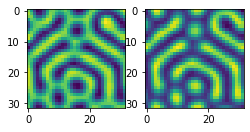

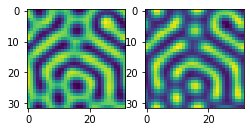

In [117]:
start = 319
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, start].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, start].reshape((x_size,y_size)))
plt.show()

#plt.subplot(131)
#plt.imshow(data[0, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.subplot(132)
#plt.imshow(data[1, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.show()

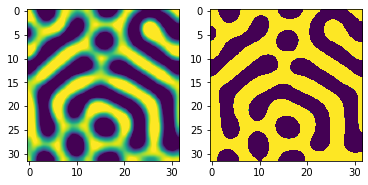

In [118]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)), interpolation='gaussian')

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)), interpolation='gaussian')
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol_sparse.gif', writer='imagemagick')

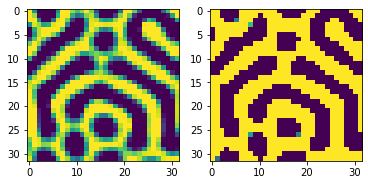

In [119]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)))

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)))
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol_sparse_2.gif', writer='imagemagick')

In [143]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = 80000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [144]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis],
           model.x_f_tf: x_2, model.y_f_tf: y_2, model.t_f_tf: t_2}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00110971
Loss_s : 0.04844390
Loss   : 195.38664246


In [145]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

179.75139573725164
15.536119960748401


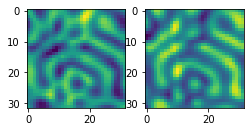

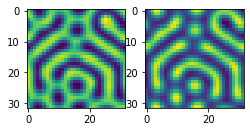

In [146]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [125]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_sampled_random', global_step=0)

'./PINN_Turring_model_loss_sampled_random-0'

In [126]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_2:0
y_tf_2:0
t_tf_2:0
a_pred_3:0
s_pred_3:0
add_68:0
loss_a_2:0
loss_s_2:0
